In [23]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from fastai.vision import *

import pydicom
import imageio

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)
from matplotlib.patches import Rectangle
import os
import seaborn as sns
torch.backends.cudnn.benchmark=True

from scipy.special import expit

In [24]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [25]:
import pandas as pd
stage_2_detailed_class_info = pd.read_csv("data/stage_2_detailed_class_info.csv")
stage_2_train_labels = pd.read_csv("data/stage_2_train_labels.csv")

In [26]:
stage_2_detailed_class_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [27]:
train_class_df = stage_2_train_labels.merge(stage_2_detailed_class_info, left_on='patientId', right_on='patientId', how='inner')

In [28]:
torch.cuda.is_available()

True

In [29]:
torch.backends.cudnn.enabled

True

In [30]:
# Looking at the CSV
stage_2_train_labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [31]:
stage_2_train_labels['Target'].unique()

array([0, 1])

In [32]:
stage_2_detailed_class_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [33]:
# Setting the path
path = Path("data")

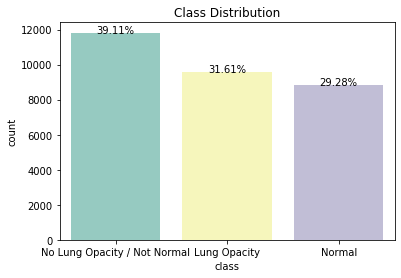

In [34]:
f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(len(stage_2_detailed_class_info))
sns.countplot(stage_2_detailed_class_info['class'],order = stage_2_detailed_class_info['class'].value_counts().index, palette='Set3').set_title('Class Distribution')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

In [35]:
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(path,"stage_2_train_images/",patientImage)
        data_row_img_data = pydicom.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = pydicom.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], data_row['class']))
        rows = train_class_df[train_class_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="yellow",alpha = 0.1))   
    plt.show()

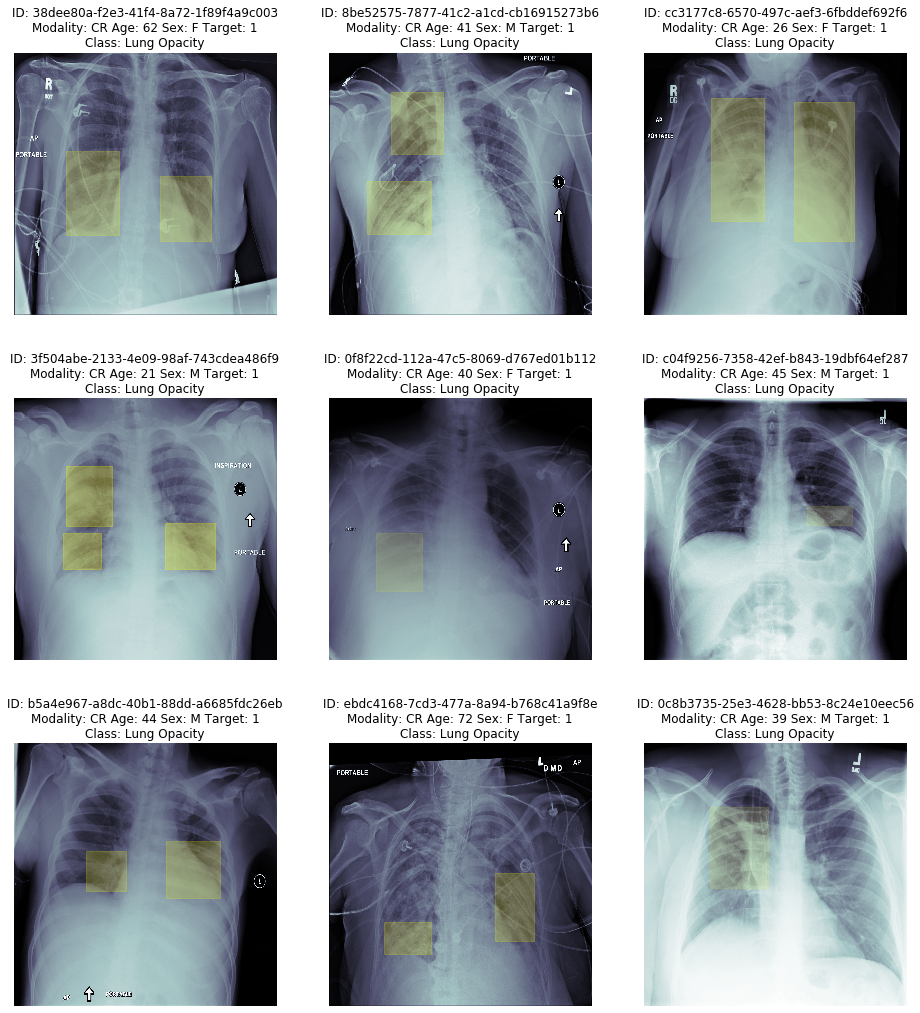

In [36]:
show_dicom_images_with_boxes(train_class_df[train_class_df['Target']==1].sample(9))

There are different kinds of opacities . Some are related to pneumonia and some are not. It is marked by the bounding boxes.

Pneumonia is a lung infection that can be caused by bacteria, viruses, or fungi. Because of the infection and the body's immune response, the sacks in the lungs (termed alveoli) are filled with fluids instead of air.

The reason that pneumonia associated lung opacities look diffuse on the chest radiograph is because the infection and fluid that accumulate spread within the normal tree of airways in the lung. There is no clear border where the infection stops. That is different from other diseases like tumors, which are totally different from the normal lung, and do not maintain the normal structure of the airways inside the lung.

In [37]:
def open_dcm_image(fn:PathOrStr,convert_mode:str='RGB',after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    array = pydicom.dcmread(fn).pixel_array
    x = PIL.Image.fromarray(array).convert('RGB')
    return Image(pil2tensor(x,np.float32).div_(255))
vision.data.open_image = open_dcm_image

In [38]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0)
data = ImageDataBunch.from_csv(path,folder='stage_2_train_images',csv_labels='stage_2_detailed_class_info.csv',ds_tfms=tfms,fn_col='patientId',label_col='class',suffix='.dcm',seed=47,size=224, bs = 128)

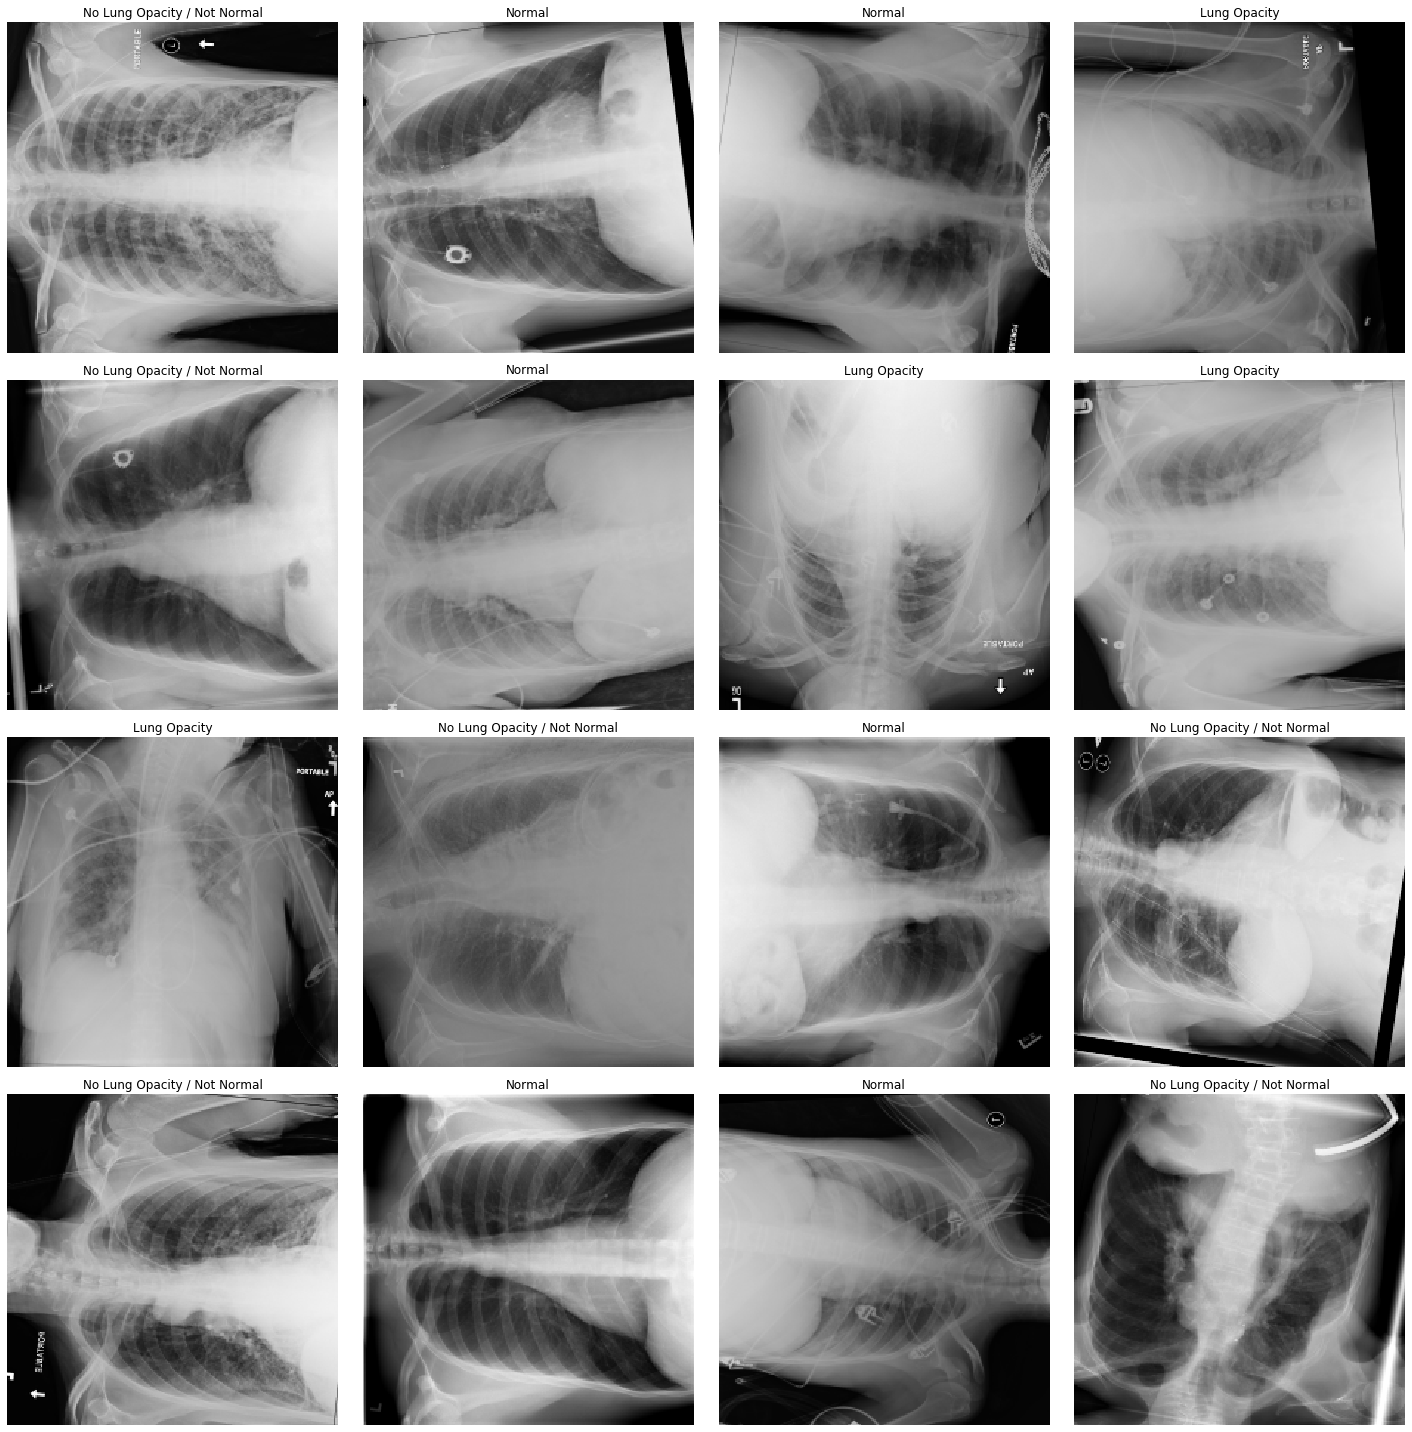

In [39]:
data.show_batch(rows=4, figsize=(20,20))

In [40]:
learner = load_learner(Path('model'), 'chexnet_NIH.pkl')
model = learner.model
def create_head(nf:int, nc:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5,
                concat_pool:bool=True, bn_final:bool=False):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes."
    lin_ftrs = [nf, 512, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = listify(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    layers = [pool, Flatten()]
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += bn_drop_lin(ni, no, True, p, actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    return nn.Sequential(*layers)

custom_head2=create_head(nf = 2048, nc = 3)
precision=Precision()
recall=Recall()
AUC=AUROC()
model_ch1 = nn.Sequential(model[:-1],custom_head2)


epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


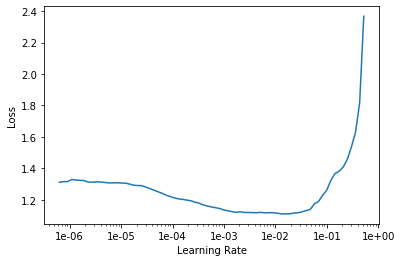

In [41]:
learn = Learner(data, model_ch1, metrics=(accuracy,precision,recall,AUC))

learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(4, max_lr =1e-3)

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time
0,0.787986,0.943276,0.615054,0.658721,0.635144,0.445001,03:08
1,0.710963,0.656368,0.704053,0.726414,0.702458,0.430613,03:08
2,0.652148,0.644837,0.708850,0.740506,0.703081,0.415117,03:05
3,0.604312,0.584719,0.736807,0.736698,0.751097,0.427408,03:03


/home/sahand/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


In [43]:
learn.save('stage-1')


In [44]:
#learn.load('stage-1-50')
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


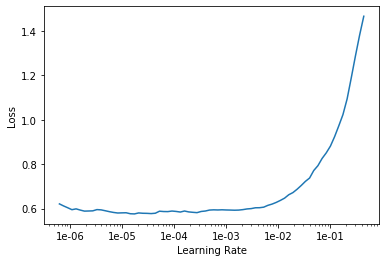

In [45]:
learn.recorder.plot()

In [46]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(2e-5))

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time
0,0.579933,0.575235,0.738627,0.740146,0.749933,0.423612,03:06
1,0.583732,0.575292,0.739289,0.740891,0.750001,0.418968,03:05
2,0.581535,0.576138,0.741605,0.745113,0.750921,0.416326,03:06
3,0.582018,0.566254,0.743093,0.746206,0.752084,0.410214,03:08
4,0.570574,0.567998,0.744251,0.748076,0.752506,0.409985,03:06


In [47]:
learn.save('stage-2')

In [48]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

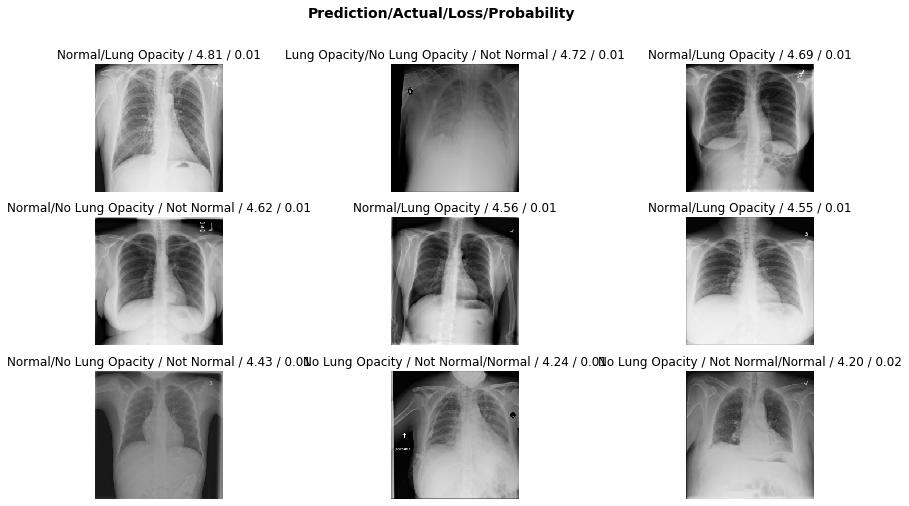

In [49]:
interp.plot_top_losses(9, figsize=(15,8))

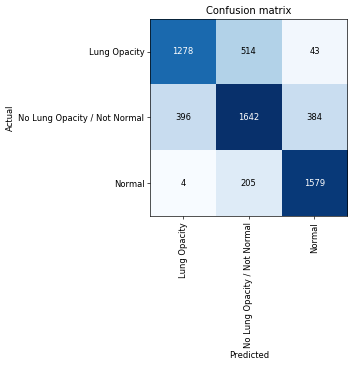

In [50]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)